In [1]:
# Imbalanced classes in a dataset can skew model boundaries (e.g. SVC, SVR) to favour the majority class
# There is a need to oversample the minority class (e.g. if only 0.5% of response is 1 and 99.5% is 0)
# Can do naive sampling of 1s by repeating them in dataset until they end up 50-50% for 0s and 1s
# By giving the 1s more "say" through more points, their error cannot be neglected and model will prioritize them more
# This is similar to using a unique RMSE or accuracy metric that weights the 1 more heavily by a ratio of beta = no of 0/no of 1s
# However some models might work differently for error weighing metric vs naive sampling

# Besides random naive sampling, there's always cool methods of making synthetic data

# SMOTE - Synthetic Minority Over-Sampling Technique
# For each rare datapoint of the minority, SMOTE finds the nearest neighbors
# Drawing a line (or line traversing multi dimensions) between the current point and nearest neighbor, a new point is created on that imaginary point
# It is a kind of interpolation that gets the middle ground between the points
# e.g. a=0, b=1, c=2, y=1 (+ve rare response) is found to have nearest neighbor of a=0.2, b=-3, c=2, y=1 (+ve response)
# Nearest neighbor is found using RMS distance of features a,b,c and y is both of 1
# Then a possible new SMOTE point is a=0.1, b=0, c=2 - notice how the points lie on the 3D line between the two points 
# Advantage of SMOTE: Synthetic observations are less likely to overfit than repeating data through naive samples
# While no data loss is present if you do oversampling of 1s (and not undersample the 0s to a small number), there is no new info
# SMOTE creates new info with the assumption that future 1s would have similar features like the 0s
# However if 1 data points are too little, data quality bad or interpolation not realistic due to circumstances, then model might not work on future data

# Adaptive Synthetic (ADASYN) - alternative to SMOTE
# While SMOTE is good in creating synthetic points, it tends to create points in between current points
# Hence the density of points will end up concentrated inside the widest permimeter of the area (or hyperdimensional volume)
# e.g. if you have a sphere of points of coordinates (a,b,c), all lines will be in the sphere or near its surface
# Hence the points spawned on the line will not be concentrated on border regions with the 0s where a clear distinction is important for models
# A better info metric might be to create points with priority at CHALLENGING region of 1s and 0s 
# Some regions might only have a few 1s and so it needs help to seperate the points more clearly by putting more 1s in neighborhood
# This may work very well for boundary based models like SVC, or random forest

# First, ADASYN finds the ratio b of 0s vs 1s. If 0 is 10 times of 1, then b=10
# G = (ml-ms)*b, where G is total number of synthetic points to create and ms and ml are weights to be set?
# Next, ADASYN finds k nearest neighbors, e.g. if there are 5 neighbors near the current 1 point, k=5
# Out of the k neighbors, the number of points that are 0s (the majority class) will be determined
# A ri value is calculated based on (no. of majority points in k neighbors)/no. of k neighbors
# e.g. if there are 5 neighbors and 3 are 0s (majority class), ri = 3/5
# Each point of response 1 will be looped through to find k neighbors and ri value
# The higher rᵢ, the more dominant the majority class and the more difficult the neighborhood for that point is to learn for your classifier.
# ADASYN normalizes the r values for all minority observations so that their sum is one.
# ADASYN computes the number of synthetic observations to generate in each neighborhood, i.e. Gi = G*ri
# where G is total number to be made, ri is ratio for the neighborhood of point i, Gi is num of points for the neighborhood
# For each point that still has a rare (response 1) neighbor nearby, the usual linear interpolation is done
# si = xi + (xzi - xi) * lambda, where lambda is random factor from 0 to 1, xi is current point, xzi is neighbor and si is new point
# Alternatively, we can mark out a plane from 3 points (of response 1) and create a point any point on that plane

# As with most algorithms, there are several extensions of SMOTE. 
# These aim to improve SMOTE by adding to its functionality or lessening its weaknesses.
# Extension of SMOTE: (examples)
# BorderlineSMOTE: Instead of oversampling between all minority observations, BorderlineSMOTE aims to increase the number of minority observations that border majority observations. 
# The goal here is to allow the classifier to be able to distinguish between these borderline observations more clearly.
# ADASYN focuses more on challenging areas with little 1s, which need not be the boundaries. But BorderlineSMOTE is more border based
# SVMSMOTE: SVMSMOTE, as its name implies, utilizes the Support Vector Machine algorithm to generate new minority observations close to the border between the majority and minority classes.

# Different algos have different ways of generating the points

In [3]:
# importing packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# reading in CSV
df = pd.read_csv('creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
102087,68047.0,-1.919985,2.161635,-0.007638,-0.090821,-0.684380,-0.362199,-0.495096,1.460793,-0.917117,...,-0.109496,-0.470316,0.156857,-0.016690,-0.062102,0.097150,0.108513,0.007307,9.42,0
69593,53495.0,0.937565,-0.251527,-0.019672,0.992319,-0.123135,0.024872,0.096008,0.125683,-0.046874,...,0.144192,0.104474,-0.215257,-0.330250,0.531800,-0.304207,-0.007529,0.022114,130.00,0
199573,133028.0,-1.166955,0.197206,-0.166187,-3.259610,1.146332,4.990452,-1.239286,-2.106628,1.466259,...,2.613893,-2.159352,-0.567234,0.734404,1.422567,0.498377,0.303421,0.077623,200.00,0
6394,7594.0,1.154254,0.283372,0.835510,1.468512,-0.510746,-0.676945,-0.144957,-0.182303,1.460631,...,-0.213593,-0.438333,0.020777,0.295094,0.368346,-0.519646,-0.000689,0.030078,36.00,0
130799,79435.0,-0.061008,-0.744399,1.800945,-2.150292,-1.040646,0.448124,-0.344005,-0.007536,-2.311161,...,0.059198,0.617976,-0.030908,-0.313231,-0.141417,-0.142070,-0.096524,-0.202511,79.00,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Text(0.5, 1.0, 'No Fraud (0) vs. Fraud (1)')

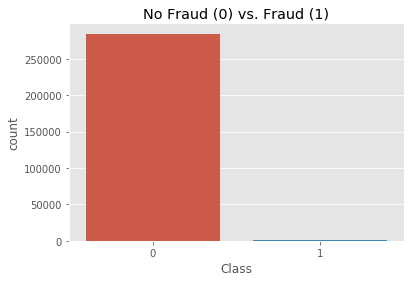

In [7]:
# taking a closer look at the class variable
sns.countplot('Class', data = df)
plt.title('No Fraud (0) vs. Fraud (1)')

In [9]:
x = df.drop(['Class'], axis=1)
y = df['Class']

In [10]:
# imports 
from imblearn.over_sampling import RandomOverSampler

# random oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x, y)

# using Counter to display results of naive oversampling
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 284315), (1, 284315)]


In [17]:
y_resampled[0:50,]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
y_resampled.sum()

284315

In [21]:
y_resampled

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [23]:
# importing SMOTE
from imblearn.over_sampling import SMOTE

# applying SMOTE to our data and checking the class counts
X_resampled2, y_resampled2 = SMOTE().fit_resample(x, y)
print(sorted(Counter(y_resampled2).items()))

[(0, 284315), (1, 284315)]

In [24]:
# importing ADASYN
from imblearn.over_sampling import ADASYN

# applying ADASYN
X_resampled3, y_resampled3 = ADASYN().fit_resample(x, y)
print(sorted(Counter(y_resampled3).items()))

[(0, 284315), (1, 284298)]


In [25]:
# BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE

X_resampled4, y_resampled4 = BorderlineSMOTE().fit_resample(x, y)
print(sorted(Counter(y_resampled4).items()))

[(0, 284315), (1, 284315)]


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [32]:
def model_train(X, Y):
    # Define search parameter values
    depth = [5,10,15,20]
    tree_amt = [50,100,150]
    RFC = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=50)

    # Create a parameter grid: map the parameter names to search values
    param_grid = dict(max_depth=depth, n_estimators=tree_amt)
    print(param_grid)

    # Instantiate and fit the grid
    grid = GridSearchCV(RFC, param_grid, cv=10, scoring='accuracy')
    grid.fit(X,Y)
    
    return grid

In [33]:
naive_sampling_model = model_train(X_resampled, y_resampled)

{'max_depth': [5, 10, 15, 20], 'n_estimators': [50, 100, 150]}


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


MemoryError: 